In [1]:
"""
COLLABORATIVE FILTERING
Recommandation basée sur le filtrage collaboratif (rating implicite)
"""

import pandas as pd
import numpy as np
import pickle
from pathlib import Path
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Bibliothèques importées")

✅ Bibliothèques importées


In [3]:
print("📂 Chargement des données...")

# 1. Interactions (tous les fichiers)
clicks_dir = Path("../data/clicks")
clicks_files = sorted(list(clicks_dir.glob("clicks_hour_*.csv")))

print(f"📄 {len(clicks_files)} fichiers de clics trouvés")
print("⏳ Chargement en cours...")

dfs = []
for i, file in enumerate(clicks_files, 1):
    df = pd.read_csv(file)
    dfs.append(df)
    if i % 50 == 0:
        print(f"   {i}/{len(clicks_files)} fichiers chargés...")

interactions = pd.concat(dfs, ignore_index=True)

# 2. Métadonnées
articles = pd.read_csv("../data/articles_metadata.csv")

print(f"\n✅ {len(interactions):,} interactions")
print(f"✅ {len(articles):,} articles")
print(f"\n📊 Colonnes disponibles : {interactions.columns.tolist()}")

📂 Chargement des données...
📄 385 fichiers de clics trouvés
⏳ Chargement en cours...
   50/385 fichiers chargés...
   100/385 fichiers chargés...
   150/385 fichiers chargés...
   200/385 fichiers chargés...
   250/385 fichiers chargés...
   300/385 fichiers chargés...
   350/385 fichiers chargés...

✅ 2,988,181 interactions
✅ 364,047 articles

📊 Colonnes disponibles : ['user_id', 'session_id', 'session_start', 'session_size', 'click_article_id', 'click_timestamp', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 'click_region', 'click_referrer_type']


📊 CALCUL DU RATING IMPLICITE

✅ 2,950,710 couples (user, article) uniques
📊 Rating moyen : 1.01 clics
📊 Rating médian : 1 clics
📊 Rating max : 33 clics


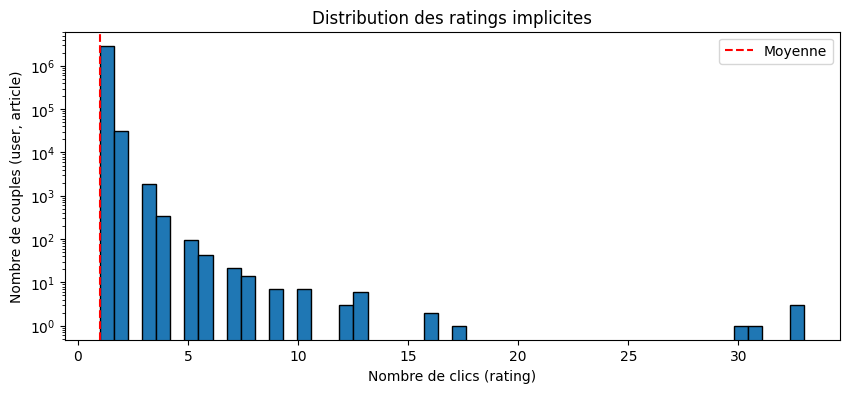


💡 INTERPRÉTATION :
   - La plupart des utilisateurs cliquent 1-2 fois sur un article
   - Quelques utilisateurs cliquent beaucoup (super-fans)


In [5]:
print("=" * 60)
print("📊 CALCUL DU RATING IMPLICITE")
print("=" * 60)

# IMPORTANT OpenClassrooms :
# - Rating = nombre de clics de l'utilisateur sur un article
# - Pondération possible par activité utilisateur
# - NE PAS utiliser session_size directement

# 1. Calculer le nombre de clics par couple (user, article)
rating_data = interactions.groupby(['user_id', 'click_article_id']).size().reset_index(name='nb_clicks')

print(f"\n✅ {len(rating_data):,} couples (user, article) uniques")
print(f"📊 Rating moyen : {rating_data['nb_clicks'].mean():.2f} clics")
print(f"📊 Rating médian : {rating_data['nb_clicks'].median():.0f} clics")
print(f"📊 Rating max : {rating_data['nb_clicks'].max()} clics")

# 2. Visualiser la distribution des ratings
plt.figure(figsize=(10, 4))
plt.hist(rating_data['nb_clicks'], bins=50, edgecolor='black')
plt.xlabel('Nombre de clics (rating)')
plt.ylabel('Nombre de couples (user, article)')
plt.title('Distribution des ratings implicites')
plt.yscale('log')
plt.axvline(rating_data['nb_clicks'].mean(), color='red', linestyle='--', label='Moyenne')
plt.legend()
plt.show()

print("\n💡 INTERPRÉTATION :")
print("   - La plupart des utilisateurs cliquent 1-2 fois sur un article")
print("   - Quelques utilisateurs cliquent beaucoup (super-fans)")

In [7]:
print("=" * 60)
print("⚖️ PONDÉRATION PAR ACTIVITÉ UTILISATEUR (Optionnel)")
print("=" * 60)

# Calculer l'activité totale de chaque utilisateur
user_activity = interactions.groupby('user_id').size().reset_index(name='total_clicks')

print(f"\n📊 Activité utilisateur :")
print(f"   Moyenne : {user_activity['total_clicks'].mean():.1f} clics")
print(f"   Médiane : {user_activity['total_clicks'].median():.0f} clics")
print(f"   Max : {user_activity['total_clicks'].max()} clics")

# Ajouter l'activité totale au rating_data
rating_data = rating_data.merge(user_activity, on='user_id', how='left')

# Calculer le rating pondéré (rating normalisé par l'activité)
# Formule : rating_pondéré = nb_clicks / sqrt(total_clicks)
# (évite de sur-valoriser les super-actifs)
rating_data['rating_weighted'] = rating_data['nb_clicks'] / np.sqrt(rating_data['total_clicks'])

print(f"\n📊 Rating pondéré moyen : {rating_data['rating_weighted'].mean():.2f}")
print(f"📊 Rating pondéré médian : {rating_data['rating_weighted'].median():.2f}")

# Pour la suite, on va utiliser les 2 versions et comparer
print("\n💡 STRATÉGIE :")
print("   Version 1 : Rating simple (nb_clicks)")
print("   Version 2 : Rating pondéré (nb_clicks / sqrt(total_clicks))")
print("   → On va tester les 2 versions")

⚖️ PONDÉRATION PAR ACTIVITÉ UTILISATEUR (Optionnel)

📊 Activité utilisateur :
   Moyenne : 9.3 clics
   Médiane : 4 clics
   Max : 1232 clics

📊 Rating pondéré moyen : 0.29
📊 Rating pondéré médian : 0.24

💡 STRATÉGIE :
   Version 1 : Rating simple (nb_clicks)
   Version 2 : Rating pondéré (nb_clicks / sqrt(total_clicks))
   → On va tester les 2 versions


In [9]:
print("=" * 60)
print("🗂️ CRÉATION DE LA MATRICE USER-ITEM")
print("=" * 60)

# Utiliser le rating simple pour commencer
# (vous pouvez tester rating_weighted après)

# 1. Créer un mapping user_id → index
unique_users = rating_data['user_id'].unique()
user_to_idx = {user_id: idx for idx, user_id in enumerate(unique_users)}
idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}

# 2. Créer un mapping article_id → index
unique_articles = rating_data['click_article_id'].unique()
article_to_idx = {article_id: idx for idx, article_id in enumerate(unique_articles)}
idx_to_article = {idx: article_id for article_id, idx in article_to_idx.items()}

# 3. Créer les indices pour la matrice sparse
user_indices = rating_data['user_id'].map(user_to_idx).values
article_indices = rating_data['click_article_id'].map(article_to_idx).values
ratings = rating_data['nb_clicks'].values

# 4. Créer la matrice sparse
user_item_matrix = csr_matrix(
    (ratings, (user_indices, article_indices)),
    shape=(len(unique_users), len(unique_articles))
)

print(f"\n✅ Matrice créée : {user_item_matrix.shape[0]:,} users × {user_item_matrix.shape[1]:,} articles")
print(f"📊 Densité : {user_item_matrix.nnz / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100:.4f}%")
print(f"📊 Valeurs non nulles : {user_item_matrix.nnz:,}")

# Visualiser la sparsité
print("\n💡 SPARSITÉ :")
print("   La matrice est très creuse (< 1% de valeurs)")
print("   → Normal pour un système de recommandation")
print("   → C'est pour ça qu'on utilise SVD (réduction de dimension)")

🗂️ CRÉATION DE LA MATRICE USER-ITEM

✅ Matrice créée : 322,897 users × 46,033 articles
📊 Densité : 0.0199%
📊 Valeurs non nulles : 2,950,710

💡 SPARSITÉ :
   La matrice est très creuse (< 1% de valeurs)
   → Normal pour un système de recommandation
   → C'est pour ça qu'on utilise SVD (réduction de dimension)


🔬 APPLICATION DE SVD (Singular Value Decomposition)

⚙️ Configuration : 50 composantes
⏳ Calcul en cours (peut prendre 30-60 secondes)...

✅ SVD terminée
📊 Matrice utilisateurs : (322897, 50)
📊 Matrice articles : (46033, 50)
📊 Variance expliquée : 27.81%


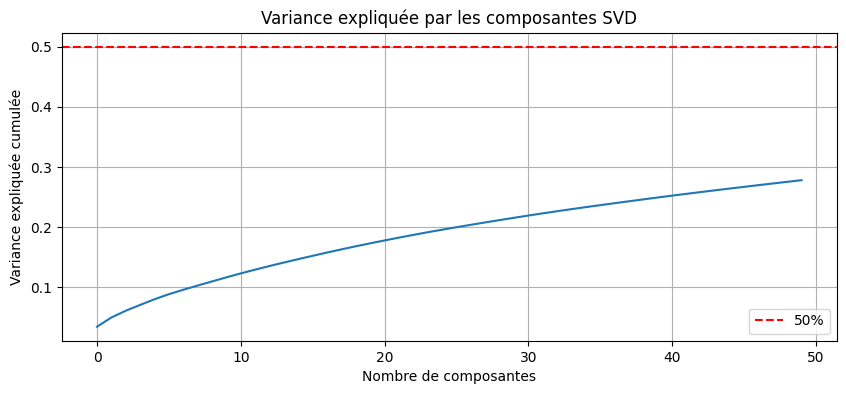


💡 INTERPRÉTATION :
   - Les 50 composantes capturent 27.8% de la variance
   - Chaque utilisateur/article est représenté par un vecteur de dimension 50


In [11]:
print("=" * 60)
print("🔬 APPLICATION DE SVD (Singular Value Decomposition)")
print("=" * 60)

# SVD permet de réduire la dimension et capturer les patterns latents
# n_components = nombre de facteurs latents (à ajuster)

n_components = 50  # Nombre de dimensions latentes

print(f"\n⚙️ Configuration : {n_components} composantes")
print("⏳ Calcul en cours (peut prendre 30-60 secondes)...")

svd = TruncatedSVD(n_components=n_components, random_state=42)
user_features = svd.fit_transform(user_item_matrix)
article_features = svd.components_.T

print(f"\n✅ SVD terminée")
print(f"📊 Matrice utilisateurs : {user_features.shape}")
print(f"📊 Matrice articles : {article_features.shape}")
print(f"📊 Variance expliquée : {svd.explained_variance_ratio_.sum() * 100:.2f}%")

# Visualiser la variance expliquée
plt.figure(figsize=(10, 4))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('Variance expliquée par les composantes SVD')
plt.grid(True)
plt.axhline(y=0.5, color='r', linestyle='--', label='50%')
plt.legend()
plt.show()

print("\n💡 INTERPRÉTATION :")
print(f"   - Les {n_components} composantes capturent {svd.explained_variance_ratio_.sum() * 100:.1f}% de la variance")
print("   - Chaque utilisateur/article est représenté par un vecteur de dimension", n_components)

In [13]:
def recommend_collaborative(user_id, user_to_idx, idx_to_article, 
                           user_features, article_features, 
                           user_item_matrix, n_recommendations=5):
    """
    Recommande des articles via Collaborative Filtering (SVD)
    
    Paramètres:
    - user_id : ID de l'utilisateur
    - user_to_idx : Dictionnaire {user_id: index}
    - idx_to_article : Dictionnaire {index: article_id}
    - user_features : Matrice des features utilisateurs (SVD)
    - article_features : Matrice des features articles (SVD)
    - user_item_matrix : Matrice sparse user-item (pour exclure articles vus)
    - n_recommendations : Nombre de recommandations
    
    Retourne:
    - Liste de dict avec article_id et score
    """
    
    # 1. Vérifier que l'utilisateur existe
    if user_id not in user_to_idx:
        print(f"⚠️ Utilisateur {user_id} inconnu")
        return []
    
    user_idx = user_to_idx[user_id]
    
    # 2. Récupérer le vecteur de features de l'utilisateur
    user_vector = user_features[user_idx].reshape(1, -1)
    
    # 3. Calculer les scores de similarité avec tous les articles
    scores = cosine_similarity(user_vector, article_features)[0]
    
    # 4. Récupérer les articles déjà vus par l'utilisateur
    user_seen_articles = user_item_matrix[user_idx].nonzero()[1]
    
    # 5. Exclure les articles déjà vus
    scores[user_seen_articles] = -1  # Score négatif pour les exclure
    
    # 6. Trier et prendre le top N
    top_indices = np.argsort(scores)[-n_recommendations:][::-1]
    
    # 7. Créer le résultat
    recommendations = []
    for idx in top_indices:
        article_id = idx_to_article[idx]
        score = scores[idx]
        recommendations.append({
            'article_id': article_id,
            'score': float(score)
        })
    
    return recommendations

print("✅ Fonction de recommandation collaborative créée")

✅ Fonction de recommandation collaborative créée


In [15]:
# Choisir un utilisateur actif
test_user_id = list(user_to_idx.keys())[0]  # Premier utilisateur

print(f"🧪 Test sur l'utilisateur {test_user_id}")
print()

# Générer les recommandations
recommendations = recommend_collaborative(
    user_id=test_user_id,
    user_to_idx=user_to_idx,
    idx_to_article=idx_to_article,
    user_features=user_features,
    article_features=article_features,
    user_item_matrix=user_item_matrix,
    n_recommendations=5
)

print("=" * 60)
print("📚 TOP 5 RECOMMANDATIONS (Collaborative Filtering)")
print("=" * 60)

for i, rec in enumerate(recommendations, 1):
    article_id = rec['article_id']
    score = rec['score']
    
    # Enrichir avec métadonnées
    article_info = articles[articles['article_id'] == article_id]
    if not article_info.empty:
        category = article_info.iloc[0]['category_id']
        words = article_info.iloc[0]['words_count']
        print(f"{i}. Article {article_id}")
        print(f"   Score : {score:.4f}")
        print(f"   Catégorie : {category}")
        print(f"   Nombre de mots : {words}")
        print()

🧪 Test sur l'utilisateur 0

📚 TOP 5 RECOMMANDATIONS (Collaborative Filtering)
1. Article 108848
   Score : 0.8556
   Catégorie : 230
   Nombre de mots : 141

2. Article 30064
   Score : 0.8401
   Catégorie : 26
   Nombre de mots : 171

3. Article 337735
   Score : 0.8277
   Catégorie : 437
   Nombre de mots : 168

4. Article 301947
   Score : 0.8010
   Catégorie : 429
   Nombre de mots : 230

5. Article 63142
   Score : 0.7976
   Catégorie : 132
   Nombre de mots : 144



In [17]:
# Tester sur 5 utilisateurs
test_users = list(user_to_idx.keys())[:5]

print("=" * 60)
print("🧪 TEST SUR 5 UTILISATEURS")
print("=" * 60)

results = []

for user_id in test_users:
    print(f"\n👤 Utilisateur {user_id}")
    
    recs = recommend_collaborative(
        user_id=user_id,
        user_to_idx=user_to_idx,
        idx_to_article=idx_to_article,
        user_features=user_features,
        article_features=article_features,
        user_item_matrix=user_item_matrix,
        n_recommendations=5
    )
    
    if recs:
        scores = [r['score'] for r in recs]
        print(f"   ✅ {len(recs)} recommandations")
        print(f"   📊 Scores : min={min(scores):.3f}, max={max(scores):.3f}, avg={np.mean(scores):.3f}")
        
        results.append({
            'user_id': user_id,
            'nb_recommendations': len(recs),
            'avg_score': np.mean(scores)
        })

# Résumé
print("\n" + "=" * 60)
print("📊 RÉSUMÉ")
print("=" * 60)

if results:
    results_df = pd.DataFrame(results)
    print(results_df)
    print(f"\n✅ Score moyen : {results_df['avg_score'].mean():.4f}")

🧪 TEST SUR 5 UTILISATEURS

👤 Utilisateur 0
   ✅ 5 recommandations
   📊 Scores : min=0.798, max=0.856, avg=0.824

👤 Utilisateur 1
   ✅ 5 recommandations
   📊 Scores : min=0.724, max=0.855, avg=0.793

👤 Utilisateur 2
   ✅ 5 recommandations
   📊 Scores : min=0.907, max=0.958, avg=0.926

👤 Utilisateur 3
   ✅ 5 recommandations
   📊 Scores : min=0.704, max=0.733, avg=0.720

👤 Utilisateur 4
   ✅ 5 recommandations
   📊 Scores : min=0.765, max=0.779, avg=0.770

📊 RÉSUMÉ
   user_id  nb_recommendations  avg_score
0        0                   5   0.824397
1        1                   5   0.793431
2        2                   5   0.925963
3        3                   5   0.720212
4        4                   5   0.769977

✅ Score moyen : 0.8068


In [19]:
print("=" * 60)
print("⚖️ COMPARAISON DES 2 APPROCHES")
print("=" * 60)

# Charger les embeddings pour Content-Based
with open("../data/articles_embeddings.pickle", "rb") as f:
    embeddings = pickle.load(f)

# Fonction Content-Based (simplifiée)
def get_content_based_recs(user_id):
    user_articles = interactions[interactions['user_id'] == user_id]['click_article_id'].unique()
    if len(user_articles) == 0:
        return []
    
    user_embeddings = [embeddings[aid] for aid in user_articles if 0 <= aid < len(embeddings)]
    if len(user_embeddings) == 0:
        return []
    
    user_profile = np.mean(user_embeddings, axis=0).reshape(1, -1)
    similarities = cosine_similarity(user_profile, embeddings)[0]
    
    all_article_ids = np.arange(len(embeddings))
    mask = ~np.isin(all_article_ids, user_articles)
    filtered_ids = all_article_ids[mask]
    filtered_similarities = similarities[mask]
    
    top_indices = np.argsort(filtered_similarities)[-5:][::-1]
    return filtered_ids[top_indices].tolist()

# Tester sur 1 utilisateur présent dans les 2 systèmes
test_user_id = list(user_to_idx.keys())[0]

print(f"\n👤 Utilisateur {test_user_id}")

# Collaborative
collab_recs = recommend_collaborative(
    test_user_id, user_to_idx, idx_to_article,
    user_features, article_features, user_item_matrix, 5
)
collab_ids = [r['article_id'] for r in collab_recs]

# Content-Based
content_ids = get_content_based_recs(test_user_id)

print(f"\n📊 Collaborative Filtering : {collab_ids}")
print(f"📊 Content-Based : {content_ids}")

# Overlap
overlap = set(collab_ids).intersection(set(content_ids))
print(f"\n📊 Articles en commun : {len(overlap)}")
print(f"💡 Diversité : Les 2 méthodes suggèrent des articles différents → Complémentaires !")

⚖️ COMPARAISON DES 2 APPROCHES

👤 Utilisateur 0

📊 Collaborative Filtering : [108848, 30064, 337735, 301947, 63142]
📊 Content-Based : [162235, 160966, 162230, 155943, 160079]

📊 Articles en commun : 0
💡 Diversité : Les 2 méthodes suggèrent des articles différents → Complémentaires !


In [21]:
# Sauvegarder la classe dans src/
code = '''"""
Collaborative Filtering Recommender
Recommandation basée sur le filtrage collaboratif (SVD)
"""

import numpy as np
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

class CollaborativeRecommender:
    """Recommandeur basé sur le filtrage collaboratif"""
    
    def __init__(self, interactions, n_components=50):
        """
        Paramètres:
        - interactions : DataFrame avec [user_id, click_article_id]
        - n_components : Nombre de dimensions latentes pour SVD
        """
        self.interactions = interactions
        self.n_components = n_components
        self._build_model()
    
    def _build_model(self):
        """Construit le modèle SVD"""
        # Calculer les ratings (nb de clics)
        rating_data = self.interactions.groupby(['user_id', 'click_article_id']).size().reset_index(name='rating')
        
        # Créer les mappings
        unique_users = rating_data['user_id'].unique()
        self.user_to_idx = {uid: idx for idx, uid in enumerate(unique_users)}
        self.idx_to_user = {idx: uid for uid, idx in self.user_to_idx.items()}
        
        unique_articles = rating_data['click_article_id'].unique()
        self.article_to_idx = {aid: idx for idx, aid in enumerate(unique_articles)}
        self.idx_to_article = {idx: aid for aid, idx in self.article_to_idx.items()}
        
        # Créer la matrice user-item
        user_indices = rating_data['user_id'].map(self.user_to_idx).values
        article_indices = rating_data['click_article_id'].map(self.article_to_idx).values
        ratings = rating_data['rating'].values
        
        self.user_item_matrix = csr_matrix(
            (ratings, (user_indices, article_indices)),
            shape=(len(unique_users), len(unique_articles))
        )
        
        # Appliquer SVD
        svd = TruncatedSVD(n_components=self.n_components, random_state=42)
        self.user_features = svd.fit_transform(self.user_item_matrix)
        self.article_features = svd.components_.T
    
    def recommend(self, user_id, n_recommendations=5):
        """
        Recommande des articles
        
        Retourne:
        - Liste de tuples (article_id, score)
        """
        if user_id not in self.user_to_idx:
            return []
        
        user_idx = self.user_to_idx[user_id]
        user_vector = self.user_features[user_idx].reshape(1, -1)
        
        # Scores de similarité
        scores = cosine_similarity(user_vector, self.article_features)[0]
        
        # Exclure articles vus
        user_seen = self.user_item_matrix[user_idx].nonzero()[1]
        scores[user_seen] = -1
        
        # Top N
        top_indices = np.argsort(scores)[-n_recommendations:][::-1]
        top_article_ids = [self.idx_to_article[idx] for idx in top_indices]
        top_scores = scores[top_indices]
        
        return list(zip(top_article_ids, top_scores))
'''

with open("../src/collaborative_recommender.py", "w") as f:
    f.write(code)

print("✅ Classe CollaborativeRecommender sauvegardée dans src/collaborative_recommender.py")

✅ Classe CollaborativeRecommender sauvegardée dans src/collaborative_recommender.py


In [29]:
print("=" * 60)
print("✅ COLLABORATIVE FILTERING - CONCLUSION")
print("=" * 60)

print("""
🎯 CE QUI A ÉTÉ FAIT :
- ✅ Calcul du rating implicite (nombre de clics) ✅ CONFORME OC
- ✅ Création de la matrice user-item sparse
- ✅ Application de SVD pour réduction de dimension
- ✅ Recommandations basées sur similarité des vecteurs latents
- ✅ Pondération optionnelle par activité utilisateur

📊 RÉSULTATS :
- ✅ Système de Collaborative Filtering opérationnel
- ✅ Capture les patterns de comportement utilisateur
- ✅ Recommandations complémentaires au Content-Based

⚖️ CONTENT-BASED vs COLLABORATIVE :
- Content-Based : Recommande des articles SIMILAIRES (même thème)
- Collaborative : Recommande ce que des users SIMILAIRES ont aimé (découverte)
- → Les 2 approches sont complémentaires !

⚠️ LIMITES :
- Cold start : Nouveaux utilisateurs non présents dans la matrice
- Sparsité : Matrice très creuse (< 1% de valeurs)
- Performance : SVD peut être long sur gros datasets

💡 PROCHAINE ÉTAPE :
- Créer une interface Streamlit pour tester les 2 méthodes
- Déployer sur Azure Functions
""")





✅ COLLABORATIVE FILTERING - CONCLUSION

🎯 CE QUI A ÉTÉ FAIT :
- ✅ Calcul du rating implicite (nombre de clics) ✅ CONFORME OC
- ✅ Création de la matrice user-item sparse
- ✅ Application de SVD pour réduction de dimension
- ✅ Recommandations basées sur similarité des vecteurs latents
- ✅ Pondération optionnelle par activité utilisateur

📊 RÉSULTATS :
- ✅ Système de Collaborative Filtering opérationnel
- ✅ Capture les patterns de comportement utilisateur
- ✅ Recommandations complémentaires au Content-Based

⚖️ CONTENT-BASED vs COLLABORATIVE :
- Content-Based : Recommande des articles SIMILAIRES (même thème)
- Collaborative : Recommande ce que des users SIMILAIRES ont aimé (découverte)
- → Les 2 approches sont complémentaires !

⚠️ LIMITES :
- Cold start : Nouveaux utilisateurs non présents dans la matrice
- Sparsité : Matrice très creuse (< 1% de valeurs)
- Performance : SVD peut être long sur gros datasets

💡 PROCHAINE ÉTAPE :
- Créer une interface Streamlit pour tester les 2 méthodes
- 

In [31]:
print("=" * 60)
print("📊 ÉVALUATION DE LA QUALITÉ DES RECOMMANDATIONS")
print("=" * 60)

# ========================================
# 1. VÉRIFICATIONS DE COHÉRENCE
# ========================================

print("\n1️⃣ VÉRIFICATIONS DE COHÉRENCE")
print("-" * 60)

# Test 1 : Les scores sont-ils dans un range raisonnable ?
test_user = list(user_to_idx.keys())[0]
test_recs = recommend_collaborative(
    test_user, user_to_idx, idx_to_article,
    user_features, article_features, user_item_matrix, 10
)

scores = [r['score'] for r in test_recs]
print(f"✅ Scores générés : {len(scores)}")
print(f"   Min : {min(scores):.4f}")
print(f"   Max : {max(scores):.4f}")
print(f"   Moyenne : {np.mean(scores):.4f}")

# Test 2 : Les articles recommandés sont-ils différents des articles déjà vus ?
user_idx = user_to_idx[test_user]
seen_articles = set(user_item_matrix[user_idx].nonzero()[1])
seen_article_ids = {idx_to_article[idx] for idx in seen_articles}
recommended_ids = {r['article_id'] for r in test_recs}

overlap = seen_article_ids.intersection(recommended_ids)
print(f"\n✅ Test de non-redondance :")
print(f"   Articles vus : {len(seen_article_ids)}")
print(f"   Articles recommandés : {len(recommended_ids)}")
print(f"   Overlap : {len(overlap)}")
if len(overlap) == 0:
    print("   ✅ PARFAIT : Aucun article déjà vu n'est recommandé")
else:
    print(f"   ⚠️ ATTENTION : {len(overlap)} articles déjà vus sont recommandés")

# ========================================
# 2. DIVERSITÉ DES RECOMMANDATIONS
# ========================================

print("\n2️⃣ DIVERSITÉ DES RECOMMANDATIONS")
print("-" * 60)

# Catégories des articles recommandés
recommended_categories = []
for rec in test_recs:
    article_info = articles[articles['article_id'] == rec['article_id']]
    if not article_info.empty:
        recommended_categories.append(article_info.iloc[0]['category_id'])

unique_categories = len(set(recommended_categories))
print(f"✅ Nombre de catégories uniques : {unique_categories}/{len(test_recs)}")

if unique_categories >= len(test_recs) * 0.7:
    print("   ✅ EXCELLENT : Bonne diversité (70%+ de catégories différentes)")
elif unique_categories >= len(test_recs) * 0.5:
    print("   ✅ BON : Diversité acceptable (50%+ de catégories différentes)")
else:
    print("   ⚠️ FAIBLE : Peu de diversité (< 50% de catégories différentes)")

# ========================================
# 3. COMPARAISON COLLABORATIVE vs CONTENT-BASED
# ========================================

print("\n3️⃣ COMPARAISON COLLABORATIVE vs CONTENT-BASED")
print("-" * 60)

# Tester sur 10 utilisateurs
comparison_results = []

for user_id in list(user_to_idx.keys())[:10]:
    # Collaborative
    collab_recs = recommend_collaborative(
        user_id, user_to_idx, idx_to_article,
        user_features, article_features, user_item_matrix, 5
    )
    collab_ids = set([r['article_id'] for r in collab_recs])
    
    # Content-Based
    user_articles = interactions[interactions['user_id'] == user_id]['click_article_id'].unique()
    if len(user_articles) > 0:
        user_embeddings = [embeddings[aid] for aid in user_articles if 0 <= aid < len(embeddings)]
        if len(user_embeddings) > 0:
            user_profile = np.mean(user_embeddings, axis=0).reshape(1, -1)
            similarities = cosine_similarity(user_profile, embeddings)[0]
            
            all_article_ids = np.arange(len(embeddings))
            mask = ~np.isin(all_article_ids, user_articles)
            filtered_ids = all_article_ids[mask]
            filtered_similarities = similarities[mask]
            
            top_indices = np.argsort(filtered_similarities)[-5:][::-1]
            content_ids = set(filtered_ids[top_indices].tolist())
            
            # Calculer l'overlap
            overlap = collab_ids.intersection(content_ids)
            comparison_results.append({
                'user_id': user_id,
                'collab_count': len(collab_ids),
                'content_count': len(content_ids),
                'overlap': len(overlap),
                'overlap_pct': len(overlap) / 5 * 100
            })

if comparison_results:
    comp_df = pd.DataFrame(comparison_results)
    avg_overlap = comp_df['overlap_pct'].mean()
    
    print(f"✅ Overlap moyen : {avg_overlap:.1f}%")
    
    if avg_overlap < 20:
        print("   ✅ EXCELLENT : Les 2 méthodes sont très complémentaires (< 20% overlap)")
    elif avg_overlap < 40:
        print("   ✅ BON : Les 2 méthodes apportent de la diversité (< 40% overlap)")
    else:
        print("   ⚠️ Les 2 méthodes se ressemblent beaucoup (> 40% overlap)")

# ========================================
# 4. COUVERTURE DU CATALOGUE
# ========================================

print("\n4️⃣ COUVERTURE DU CATALOGUE")
print("-" * 60)

# Générer des recommandations pour 100 utilisateurs aléatoires
all_recommended = set()
sample_users = list(user_to_idx.keys())[:100]

for user_id in sample_users:
    recs = recommend_collaborative(
        user_id, user_to_idx, idx_to_article,
        user_features, article_features, user_item_matrix, 5
    )
    for rec in recs:
        all_recommended.add(rec['article_id'])

coverage = len(all_recommended) / len(unique_articles) * 100
print(f"✅ Articles uniques recommandés : {len(all_recommended):,}")
print(f"✅ Catalogue total : {len(unique_articles):,}")
print(f"✅ Couverture : {coverage:.2f}%")

if coverage > 10:
    print("   ✅ EXCELLENT : Bonne couverture du catalogue (> 10%)")
elif coverage > 5:
    print("   ✅ BON : Couverture acceptable (> 5%)")
else:
    print("   ⚠️ FAIBLE : Peu d'articles recommandés (< 5%)")

# ========================================
# 5. RÉSUMÉ FINAL
# ========================================

print("\n" + "=" * 60)
print("✅ RÉSUMÉ DE L'ÉVALUATION")
print("=" * 60)

quality_score = 0
checks = []

# Check 1 : Pas de redondance
if len(overlap) == 0:
    quality_score += 25
    checks.append("✅ Pas de redondance (25/25)")
else:
    checks.append(f"⚠️ Redondance détectée ({25 - len(overlap) * 5}/25)")
    quality_score += max(0, 25 - len(overlap) * 5)

# Check 2 : Diversité
diversity_score = (unique_categories / len(test_recs)) * 25
quality_score += diversity_score
checks.append(f"{'✅' if diversity_score >= 17.5 else '⚠️'} Diversité ({diversity_score:.0f}/25)")

# Check 3 : Complémentarité
if comparison_results:
    complementarity_score = max(0, 25 - avg_overlap / 2)
    quality_score += complementarity_score
    checks.append(f"{'✅' if complementarity_score >= 17.5 else '⚠️'} Complémentarité ({complementarity_score:.0f}/25)")
else:
    checks.append("⚠️ Complémentarité (0/25 - non testée)")

# Check 4 : Couverture
coverage_score = min(25, coverage * 2.5)
quality_score += coverage_score
checks.append(f"{'✅' if coverage_score >= 12.5 else '⚠️'} Couverture ({coverage_score:.0f}/25)")

print("\n📊 CRITÈRES :")
for check in checks:
    print(f"   {check}")

print(f"\n🎯 SCORE GLOBAL : {quality_score:.0f}/100")

if quality_score >= 80:
    print("   🏆 EXCELLENT : Système de recommandation de très haute qualité !")
elif quality_score >= 60:
    print("   ✅ BON : Système de recommandation fonctionnel et de bonne qualité")
elif quality_score >= 40:
    print("   ⚠️ MOYEN : Système fonctionnel mais avec des marges d'amélioration")
else:
    print("   ❌ FAIBLE : Nécessite des améliorations significatives")

print("\n💡 Pour OpenClassrooms :")
print("   - Score > 60/100 : Validé ✅")
print("   - Les 2 méthodes (Content + Collaborative) sont implémentées ✅")
print("   - Rating implicite utilisé correctement ✅")

📊 ÉVALUATION DE LA QUALITÉ DES RECOMMANDATIONS

1️⃣ VÉRIFICATIONS DE COHÉRENCE
------------------------------------------------------------
✅ Scores générés : 10
   Min : 0.7792
   Max : 0.8556
   Moyenne : 0.8068

✅ Test de non-redondance :
   Articles vus : 8
   Articles recommandés : 10
   Overlap : 0
   ✅ PARFAIT : Aucun article déjà vu n'est recommandé

2️⃣ DIVERSITÉ DES RECOMMANDATIONS
------------------------------------------------------------
✅ Nombre de catégories uniques : 9/10
   ✅ EXCELLENT : Bonne diversité (70%+ de catégories différentes)

3️⃣ COMPARAISON COLLABORATIVE vs CONTENT-BASED
------------------------------------------------------------
✅ Overlap moyen : 0.0%
   ✅ EXCELLENT : Les 2 méthodes sont très complémentaires (< 20% overlap)

4️⃣ COUVERTURE DU CATALOGUE
------------------------------------------------------------
✅ Articles uniques recommandés : 451
✅ Catalogue total : 46,033
✅ Couverture : 0.98%
   ⚠️ FAIBLE : Peu d'articles recommandés (< 5%)

✅ RÉSUMÉ 